In [15]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [16]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [17]:
df.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [18]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [19]:
# Data Cleaning
# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']


# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

#Convert Columns from object to integer
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

#Rename murder column to 'Murder'
df = df.rename(columns = {'Murder and Nonnegligent Manslaughter':'Murder'})

# Change name of Property Crime and Aggravated Assault so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Rape'] = df['Rape (legacy definition)']
df = df.drop(columns=['Rape (legacy definition)'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])

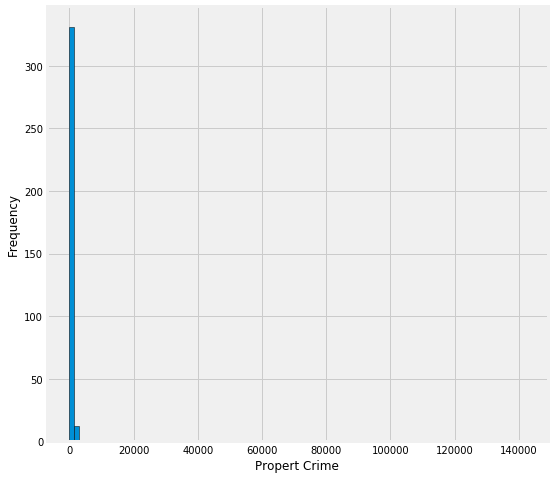

In [20]:
plt.figure(figsize=(8,8))
plt.hist(df['Propertycrime'], bins = 100, edgecolor='k')
plt.xlabel('Propert Crime')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df['Population^2'] = df['Population']**2
df['Murder'] = np.where(df['Murder']>0, '1', '0')
df['Robbery_binary'] = np.where(df['Robbery']>0, '1', '0')
df['Aggravated_Assault'] = np.where(df['Aggravated_Assault']>0, '1', '0')
df['Violent Crime'] = np.where(df['Violent Crime']>0, '1', '0')
df['Rape'] = np.where(df['Rape']>0, '1', '0')
df['Robbery'] = np.where(df['Robbery']>0, '1', '0')
df['Burglary'] = np.where(df['Burglary']>0, '1', '0')
df['Larceny-Theft'] = np.where(df['Larceny-Theft']>0, '1', '0')
df['Motor Vehicle Theft'] = np.where(df['Motor Vehicle Theft']>0, '1', '0')
df['Propertycrime '] = np.where(df['Propertycrime']>0, '1', '0')


#Convert new columns to int
df[['Population', 'Violent Crime',
       'Murder', 'Rape',
       'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder', 'Rape', 'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

In [ ]:
# Removing outliers seem largely inconsequential on the skew of the data as the medians tend to hover around 0 
# for most of the variables. Removing outliers, therefore, does not improve the skew of distributions.
# A more significant change may be to convert all variables to Binary Variables, given the fact that
# there are many 0 values in each variable any way.
# Based on the predictor of whether the certain type of crime occurs, or not, we may be able to gain more insight
# on predicting Murder.

In [ ]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))

In [ ]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train,).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

In [ ]:
# Cross-validation with mutliple folds
from sklearn.model_selection import cross_val_score

cross_val_score(regr, x, y, cv=5)

In [ ]:
# Test for significance in parameters
linear_formula = 'Propertycrime ~ Population+Population^2+Murder+Robbery_binary'

# Fit the model to our data using formula
lm = smf.ols(formula=linear_formula, data=df).fit()

In [ ]:
lm.params

In [ ]:
lm.pvalues

In [ ]:
# Create PCA on the follwing variables: Burglary, Violent Crime, Aggravated_Assault, Larceny-Theft, Motor-Vehicle Theft, Robbery

# Standardize Data
features = ['Burglary', 'Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']
x = df.loc[:, features].values

scaler = StandardScaler()

scaler.fit(x)

pd.DataFrame(data=x, columns=features).head()

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create Merged Data Frame
principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent_1', 'principalcomponent_2'])
principalDf['City'] = df['City']
merged_inner = pd.merge(left=df, right=principalDf, left_on='City', right_on='City')
df = merged_inner

In [ ]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary', 'principalcomponent_1', 'principalcomponent_2']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))

In [ ]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=50)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train,).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))